In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Dropout

In [ ]:
df = pd.read_csv('/content/ltedata.csv')

In [ ]:
data = df
data.head(10)


,date,Length
0,1970-01-01 00:00:00.000,195.000000
1,1970-01-01 00:00:00.001,102.200000
2,1970-01-01 00:00:00.002,259.851852
3,1970-01-01 00:00:00.003,120.266667
4,1970-01-01 00:00:00.004,118.833333
5,1970-01-01 00:00:00.005,125.750000
6,1970-01-01 00:00:00.006,132.666667
7,1970-01-01 00:00:00.007,96.400000
8,1970-01-01 00:00:00.008,149.000000
9,1970-01-01 00:00:00.009,93.428571


In [ ]:
train_data = data['Length'].astype(float)
train_data.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6943 entries, 0 to 6942
Series name: Length
Non-Null Count  Dtype  
--------------  -----  
6943 non-null   float64
dtypes: float64(1)
memory usage: 54.4 KB


<Axes: >

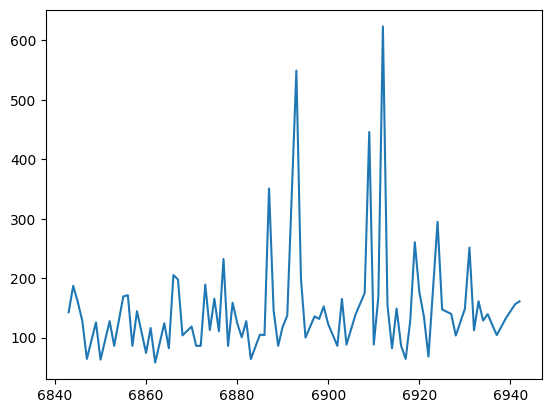

In [ ]:
dfp=train_data.tail(100)
dfp.plot.line()

In [ ]:
numeric_columns = data.select_dtypes(include=['float64']).columns
numeric_data = data[numeric_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform only the numeric data
scaled_data = scaler.fit_transform(numeric_data)


In [ ]:
scaled_data

array([[ 0.05877619],
       [-0.45875467],
       [ 0.42044467],
       ...,
       [-0.22480618],
       [-0.15983598],
       [-0.13083641]])

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
X, y = split_sequence(scaled_data, 20)

X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Compute the attention scores
        uit = K.tanh(K.dot(x, self.W) + self.b)
        ait = K.dot(uit, K.expand_dims(self.u))
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        # Apply attention scores to the input
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(X.shape[1], X.shape[2]))

# Define the LSTM layers
lstm1 = LSTM(256, activation='relu', return_sequences=True)(input_layer)
lstm2 = LSTM(128, activation='relu', return_sequences=True)(lstm1)
lstm3 = LSTM(64, activation='relu', return_sequences=True)(lstm2)

# Add the attention layer
attention = Attention()(lstm3)

# Add dropout and dense layers
dropout = Dropout(0.1)(attention)
dense1 = Dense(10, activation='relu')(dropout)
output_layer = Dense(1)(dense1)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Summary of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 256)           264192    
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            49408     
                                                                 
 attention (Attention)       (None, 64)                4224      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650   

In [ ]:
hist = model.fit(X, y, epochs=1000,batch_size = 258, validation_split=0.01, verbose=1)

Epoch 1/1000
27/27 [==============================] - 11s 124ms/step - loss: 1.0063 - mae: 0.6860 - val_loss: 0.3115 - val_mae: 0.3809
Epoch 2/1000
27/27 [==============================] - 3s 120ms/step - loss: 0.9906 - mae: 0.6774 - val_loss: 0.3012 - val_mae: 0.3570
Epoch 3/1000
27/27 [==============================] - 2s 81ms/step - loss: 0.9542 - mae: 0.6672 - val_loss: 0.2952 - val_mae: 0.3600
Epoch 4/1000
27/27 [==============================] - 2s 81ms/step - loss: 0.9342 - mae: 0.6498 - val_loss: 0.2895 - val_mae: 0.3516
Epoch 5/1000
27/27 [==============================] - 2s 81ms/step - loss: 0.9082 - mae: 0.6486 - val_loss: 0.2945 - val_mae: 0.3442
Epoch 6/1000
27/27 [==============================] - 2s 90ms/step - loss: 0.8651 - mae: 0.6228 - val_loss: 0.2950 - val_mae: 0.3651
Epoch 7/1000
27/27 [==============================] - 4s 132ms/step - loss: 0.8422 - mae: 0.6194 - val_loss: 0.2964 - val_mae: 0.3584
Epoch 8/1000
27/27 [==============================] - 2s 81ms/ste

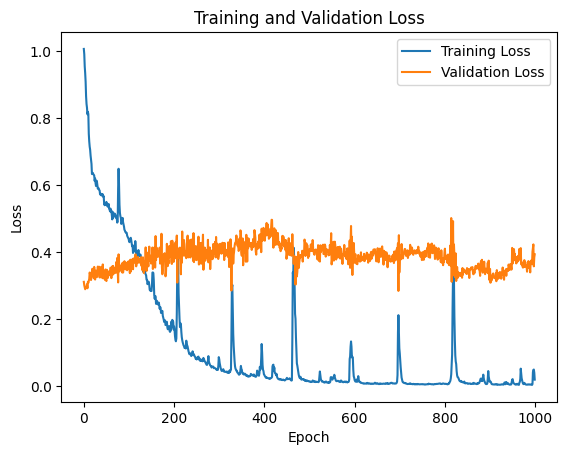

In [ ]:
# Plot training loss
plt.plot(hist.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(hist.history['val_loss'], label='Validation Loss')

# Customize the plot
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


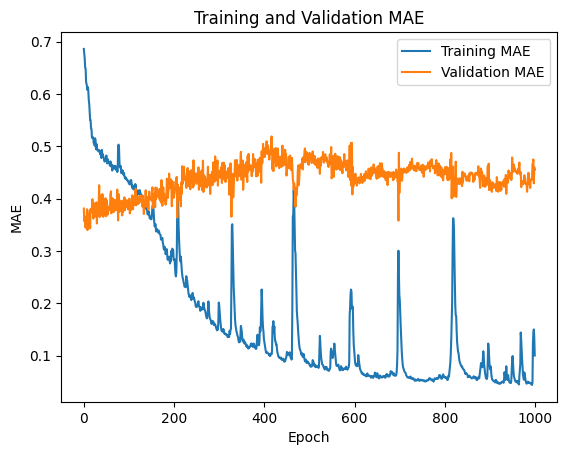

In [ ]:
plt.plot(hist.history['mae'], label='Training MAE')

# Plot validation MAE
plt.plot(hist.history['val_mae'], label='Validation MAE')

# Customize the plot
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
forecast= model.predict(X[-200:])

7/7 [==============================] - 1s 26ms/step


In [ ]:
hist.history

{'loss': [1.0062744617462158,
  0.990566074848175,
  0.9542247653007507,
  0.9342345595359802,
  0.9082109332084656,
  0.8650662899017334,
  0.8421513438224792,
  0.830956220626831,
  0.8113648295402527,
  0.8186909556388855,
  0.8118715882301331,
  0.7532061338424683,
  0.7302513122558594,
  0.7146661281585693,
  0.705367922782898,
  0.6881006360054016,
  0.6754177212715149,
  0.6633316874504089,
  0.6329843401908875,
  0.6333017945289612,
  0.6364630460739136,
  0.6323280930519104,
  0.6310347318649292,
  0.6285557746887207,
  0.6126874685287476,
  0.6197938323020935,
  0.6059859395027161,
  0.5974063277244568,
  0.613472044467926,
  0.6108846664428711,
  0.5990391373634338,
  0.5893168449401855,
  0.5917526483535767,
  0.5900259613990784,
  0.5853439569473267,
  0.5841375589370728,
  0.5721852779388428,
  0.5744572281837463,
  0.5741601586341858,
  0.5691357254981995,
  0.5736780762672424,
  0.5696482062339783,
  0.572658121585846,
  0.5651397705078125,
  0.5670552849769592,
  0.546

In [ ]:
unscaled_data = scaler.inverse_transform(forecast)

unscaled_data

array([[295.10287  ],
       [364.5585   ],
       [149.05147  ],
       [223.53462  ],
       [ 95.08534  ],
       [221.77058  ],
       [155.35912  ],
       [443.24445  ],
       [751.05865  ],
       [204.24487  ],
       [291.9998   ],
       [125.20554  ],
       [210.20778  ],
       [ 87.16103  ],
       [174.40149  ],
       [152.0879   ],
       [106.46114  ],
       [ 95.02892  ],
       [108.29368  ],
       [ 45.413    ],
       [ 51.56966  ],
       [  5.1997867],
       [ 34.982533 ],
       [135.02216  ],
       [304.89984  ],
       [158.40369  ],
       [307.44424  ],
       [201.80952  ],
       [ 82.11451  ],
       [322.85486  ],
       [521.9567   ],
       [196.53905  ],
       [186.77692  ],
       [275.926    ],
       [160.20312  ],
       [317.349    ],
       [363.18585  ],
       [347.65826  ],
       [ 96.4027   ],
       [834.87695  ],
       [179.19342  ],
       [110.22338  ],
       [476.31436  ],
       [702.7353   ],
       [428.9237   ],
       [18

In [ ]:
kat = unscaled_data.flatten()

indic = data['date'][-200:]

df_fore = pd.DataFrame({'index':indic,'length':kat})



<Axes: >

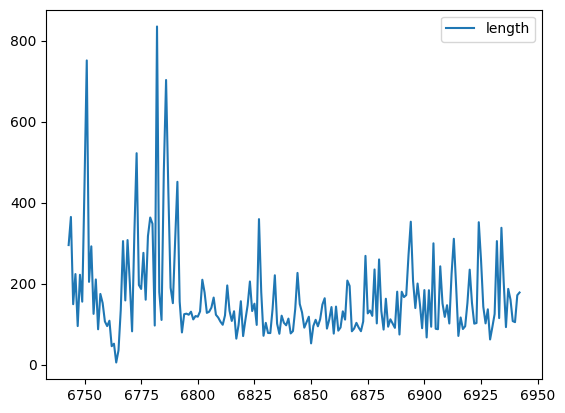

In [ ]:
dfp=df_fore.tail(200)

sns.lineplot(dfp )

In [ ]:
dp=train_data.tail(200)

<Axes: >

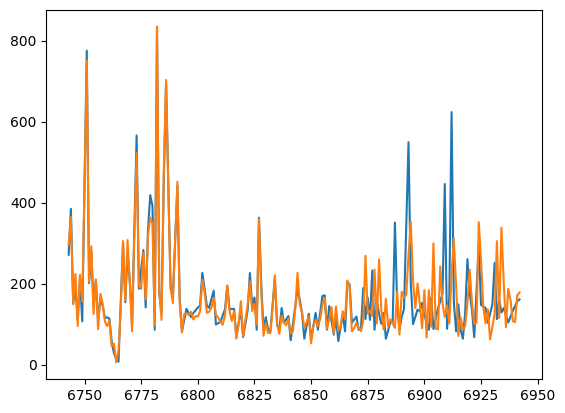

In [ ]:
dp.plot.line()
dfp['length'].plot.line()